
Analyzing New York Taxi Data Using PySpark on Azure (Free Tier)
Introduction
You are a data engineer at a transportation analytics company. Your team has been tasked with analyzing the New York City taxi dataset to uncover insights that can help improve taxi services, optimize routes, and understand customer behavior. The dataset is large, but you decide to use PySpark on Azure Databricks to handle the data processing efficiently.

Step 1: Setting Up the Environment
Story:
You start by setting up your cloud environment. Azure Databricks is chosen because it provides a collaborative, scalable, and managed platform for big data analytics with PySpark. You create a Databricks workspace and a small cluster, and configure it to read data from an Azure Blob Storage account where the dataset is stored.

Mini Tasks:

Create a free Azure account if you don’t already have one.
Set up an Azure Blob Storage account and upload a subset of the New York taxi dataset (e.g., trip_data.csv and trip_fare.csv).
Create an Azure Databricks workspace and launch a small cluster with PySpark installed.
Mount the Blob Storage container to your Databricks workspace using the abfss protocol or a SAS token.
Verify that PySpark is working by running a simple script to print "Hello, PySpark!"
Step 2: Loading and Exploring the Data
Story:
With the environment ready, you load the dataset into PySpark DataFrames. The dataset contains information about taxi trips, including pickup/dropoff locations, timestamps, trip distances, fares, and payment types. You begin by exploring the data to understand its structure and identify any quality issues.

Mini Tasks:

Load a subset of the trip_data.csv and trip_fare.csv files from Blob Storage into PySpark DataFrames.
Print the schema of both DataFrames to understand the column names and data types.
Check for missing values and duplicates in the dataset.
Display the first 5 rows of each DataFrame to get a sense of the data.
Step 3: Data Cleaning and Transformation
Story:
You notice some inconsistencies in the data, such as missing values in the passenger_count column and incorrect timestamps. You decide to clean the data by removing invalid records and transforming columns into the correct formats.

Mini Tasks:

Drop rows with missing values in critical columns like pickup_datetime, dropoff_datetime, and trip_distance.
Convert the pickup_datetime and dropoff_datetime columns to timestamp format.
Filter out rows where trip_distance is 0 or negative.
Create a new column trip_duration by calculating the difference between dropoff_datetime and pickup_datetime.
Step 4: Joining Datasets
Story:
To get a complete picture of each trip, you decide to join the trip_data and trip_fare DataFrames using a common key, such as medallion and hack_license. This will allow you to analyze both trip details and fare information together.

Mini Tasks:

Identify the common columns between trip_data and trip_fare DataFrames.
Perform an inner join on the two DataFrames using the common columns.
Verify the join by checking the row count and inspecting the resulting DataFrame.
Step 5: Analyzing the Data
Story:
With the cleaned and joined dataset, you start analyzing it to uncover insights. You focus on answering key questions, such as:

What is the average trip duration and fare?
Which payment methods are most popular?
What are the peak hours for taxi rides?
Mini Tasks:

Calculate the average trip_duration and fare_amount.
Group the data by payment_type and count the number of trips for each payment method.
Extract the hour from pickup_datetime and create a histogram to visualize peak hours.
Identify the top 5 pickup and dropoff locations based on trip frequency.
Step 6: Visualizing the Results
Story:
To make your findings more accessible, you decide to visualize the results using Databricks' built-in visualization tools or a Python library like Matplotlib or Seaborn. You export the aggregated data from PySpark to a Pandas DataFrame for easier plotting.

Mini Tasks:

Export the results of your analysis (e.g., average fare, peak hours) to a Pandas DataFrame.
Create a bar chart to show the distribution of payment types.
Plot a line chart to visualize the number of trips per hour (peak hours).
Generate a scatter plot to explore the relationship between trip_distance and fare_amount.
Step 7: Saving the Results
Story:
Finally, you save the cleaned dataset and analysis results back to Blob Storage for future use. You also document your findings in a report that will be shared with your team.

Mini Tasks:

Save the cleaned and joined DataFrame as a Parquet file in your Blob Storage account.
Export the aggregated results (e.g., peak hours, payment types) as a CSV file to Blob Storage.
Write a brief summary of your findings in a Markdown file and upload it to Blob Storage.
Conclusion
Story:
You’ve successfully built a PySpark pipeline to analyze the New York taxi dataset on Azure. Your analysis revealed valuable insights, such as peak hours, popular payment methods, and average trip durations. These findings will help your team make data-driven decisions to improve taxi services in New York City.

Mini Tasks:

Terminate the Databricks cluster to avoid unnecessary costs.
Share the Blob Storage links to the cleaned data, analysis results, and report with your team.


In [0]:
%python
# Define the variables
storage_account_name = "naked3mtt"
container_name = "trip-data"
sas_token = "sv=2024-11-04&ss=bfqt&srt=sco&sp=rwdlacupiytfx&se=2025-07-18T22:31:21Z&st=2025-07-18T14:16:21Z&spr=https&sig=%2BdOvD7h0LhPcF%2BmbeagCOXLVVfv838918QZDYRweyrs%3D"

# Construct the URL
file_location = f"wasbs://{container_name}@{storage_account_name}.blob.core.windows.net/"
spark.conf.set(f"fs.azure.sas.{container_name}.{storage_account_name}.blob.core.windows.net", sas_token)

# List files in the container
display(dbutils.fs.ls(file_location))

path name size modificationTime wasbs://trip-data@naked3mtt.blob.core.windows.net/2017_Yellow_Taxi_Trip_Data.csv 2017_Yellow_Taxi_Trip_Data.csv 2301029 1752850555000 wasbs://trip-data@naked3mtt.blob.core.windows.net/taxi_tripdata.csv taxi_tripdata.csv 7591709 1752848978000

In [0]:
from pyspark.sql import functions as F# Load all CSV files from the container into PySpark DataFrames

file_paths = [f.path for f in dbutils.fs.ls(file_location) if f.path.endswith('.csv')]

df_spark_1 = spark.read.option("header", "true").option("inferSchema", "true").csv(file_paths[0])
df_spark_2 = spark.read.option("header", "true").option("inferSchema", "true").csv(file_paths[1])

# Print schema of both DataFrames
df_spark_1.printSchema()
df_spark_2.printSchema()

# Check for missing values in both DataFrames
missing_1 = df_spark_1.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_spark_1.columns])
missing_2 = df_spark_2.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_spark_2.columns])
display(missing_1)
display(missing_2)

# Check for duplicates in both DataFrames
duplicates_1 = df_spark_1.count() - df_spark_1.dropDuplicates().count()
duplicates_2 = df_spark_2.count() - df_spark_2.dropDuplicates().count()
print(f"Duplicates in df_spark_1: {duplicates_1}")
print(f"Duplicates in df_spark_2: {duplicates_2}")

# Display first 5 rows of each DataFrame
display(df_spark_1.limit(5))
display(df_spark_2.limit(5))

root
 |-- _c0: integer (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string 

_c0 VendorID tpep_pickup_datetime tpep_dropoff_datetime passenger_count trip_distance RatecodeID store_and_fwd_flag PULocationID DOLocationID payment_type fare_amount extra mta_tax tip_amount tolls_amount improvement_surcharge total_amount 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag RatecodeID PULocationID DOLocationID passenger_count trip_distance fare_amount extra mta_tax tip_amount tolls_amount ehail_fee improvement_surcharge total_amount payment_type trip_type congestion_surcharge 32518 0 0 32518 32518 0 0 32518 0 0 0 0 0 0 83691 0 0 32518 32518 32518

Duplicates in df_spark_1: 0
Duplicates in df_spark_2: 0


_c0 VendorID tpep_pickup_datetime tpep_dropoff_datetime passenger_count trip_distance RatecodeID store_and_fwd_flag PULocationID DOLocationID payment_type fare_amount extra mta_tax tip_amount tolls_amount improvement_surcharge total_amount 24870114 2 03/25/2017 8:55:43 AM 03/25/2017 9:09:47 AM 6 3.34 1 N 100 231 1 13.0 0.0 0.5 2.76 0.0 0.3 16.56 35634249 1 04/11/2017 2:53:28 PM 04/11/2017 3:19:58 PM 1 1.8 1 N 186 43 1 16.0 0.0 0.5 4.0 0.0 0.3 20.8 106203690 1 12/15/2017 7:26:56 AM 12/15/2017 7:34:08 AM 1 1.0 1 N 262 236 1 6.5 0.0 0.5 1.45 0.0 0.3 8.75 38942136 2 05/07/2017 1:17:59 PM 05/07/2017 1:48:14 PM 1 3.7 1 N 188 97 1 20.5 0.0 0.5 6.39 0.0 0.3 27.69 30841670 2 04/15/2017 11:32:20 PM 04/15/2017 11:49:03 PM 1 4.37 1 N 4 112 2 16.5 0.5 0.5 0.0 0.0 0.3 17.8

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag RatecodeID PULocationID DOLocationID passenger_count trip_distance fare_amount extra mta_tax tip_amount tolls_amount ehail_fee improvement_surcharge total_amount payment_type trip_type congestion_surcharge 1 2021-07-01T00:30:52Z 2021-07-01T00:35:36Z N 1 74 168 1 1.2 6.0 0.5 0.5 0.0 0.0 null 0.3 7.3 2 1 0.0 2 2021-07-01T00:25:36Z 2021-07-01T01:01:31Z N 1 116 265 2 13.69 42.0 0.5 0.5 0.0 0.0 null 0.3 43.3 2 1 0.0 2 2021-07-01T00:05:58Z 2021-07-01T00:12:00Z N 1 97 33 1 0.95 6.5 0.5 0.5 2.34 0.0 null 0.3 10.14 1 1 0.0 2 2021-07-01T00:41:40Z 2021-07-01T00:47:23Z N 1 74 42 1 1.24 6.5 0.5 0.5 0.0 0.0 null 0.3 7.8 2 1 0.0 2 2021-07-01T00:51:32Z 2021-07-01T00:58:46Z N 1 42 244 1 1.1 7.0 0.5 0.5 0.0 0.0 null 0.3 8.3 2 1 0.0

In [0]:
%python
critical_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance']

df_spark_1_clean = (
    df_spark_1
    .dropna(subset=critical_cols)
    .withColumn('pickup_datetime', F.to_timestamp('tpep_pickup_datetime'))
    .withColumn('dropoff_datetime', F.to_timestamp('tpep_dropoff_datetime'))
    .filter(F.col('trip_distance') > 0)
    .withColumn('trip_duration', F.col('dropoff_datetime').cast("long") - F.col('pickup_datetime').cast("long"))
)

display(df_spark_1_clean)

_c0 VendorID tpep_pickup_datetime tpep_dropoff_datetime passenger_count trip_distance RatecodeID store_and_fwd_flag PULocationID DOLocationID payment_type fare_amount extra mta_tax tip_amount tolls_amount improvement_surcharge total_amount pickup_datetime dropoff_datetime trip_duration 24870114 2 03/25/2017 8:55:43 AM 03/25/2017 9:09:47 AM 6 3.34 1 N 100 231 1 13.0 0.0 0.5 2.76 0.0 0.3 16.56 null null null 35634249 1 04/11/2017 2:53:28 PM 04/11/2017 3:19:58 PM 1 1.8 1 N 186 43 1 16.0 0.0 0.5 4.0 0.0 0.3 20.8 null null null 106203690 1 12/15/2017 7:26:56 AM 12/15/2017 7:34:08 AM 1 1.0 1 N 262 236 1 6.5 0.0 0.5 1.45 0.0 0.3 8.75 null null null 38942136 2 05/07/2017 1:17:59 PM 05/07/2017 1:48:14 PM 1 3.7 1 N 188 97 1 20.5 0.0 0.5 6.39 0.0 0.3 27.69 null null null 30841670 2 04/15/2017 11:32:20 PM 04/15/2017 11:49:03 PM 1 4.37 1 N 4 112 2 16.5 0.5 0.5 0.0 0.0 0.3 17.8 null null null 23345809 2 03/25/2017 8:34:11 PM 03/25/2017 8:42:11 PM 6 2.3 1 N 161 236 1 9.0 0.5 0.5 2.06 0.0 0.3 12.36 null null null 37660487 2 05/03/2017 7:04:09 PM 05/03/2017 8:03:47 PM 1 12.83 1 N 79 241 1 47.5 1.0 0.5 9.86 0.0 0.3 59.16 null null null 69059411 2 08/15/2017 5:41:06 PM 08/15/2017 6:03:05 PM 1 2.98 1 N 237 114 1 16.0 1.0 0.5 1.78 0.0 0.3 19.58 null null null 8433159 2 02/04/2017 4:17:07 PM 02/04/2017 4:29:14 PM 1 1.2 1 N 234 249 2 9.0 0.0 0.5 0.0 0.0 0.3 9.8 null null null 95294817 1 11/10/2017 3:20:29 PM 11/10/2017 3:40:55 PM 1 1.6 1 N 239 237 1 13.0 0.0 0.5 2.75 0.0 0.3 16.55 null null null 18017909 2 03/04/2017 11:58:00 AM 03/04/2017 12:13:12 PM 1 1.77 1 N 162 142 1 11.5 0.0 0.5 2.46 0.0 0.3 14.76 null null null 18600059 2 03/05/2017 7:15:30 PM 03/05/2017 7:52:18 PM 2 18.9 2 N 236 132 1 52.0 0.0 0.5 14.58 5.54 0.3 72.92 null null null 46782248 1 06/09/2017 7:00:26 PM 06/09/2017 7:20:11 PM 1 3.0 1 N 13 148 1 15.0 1.0 0.5 3.35 0.0 0.3 20.15 null null null 94113247 2 11/06/2017 11:35:05 PM 11/06/2017 11:42:57 PM 1 2.39 1 N 209 25 1 9.5 0.5 0.5 2.16 0.0 0.3 12.96 null null null 14168279 1 02/22/2017 3:18:31 PM 02/22/2017 3:42:50 PM 1 3.3 1 N 238 161 1 17.5 0.0 0.5 4.55 0.0 0.3 22.85 null null null 47444401 2 06/02/2017 6:41:39 AM 06/02/2017 6:57:47 AM 1 5.93 1 N 239 231 1 19.0 0.0 0.5 3.0 0.0 0.3 22.8 null null null 69088676 1 08/15/2017 7:48:08 PM 08/15/2017 8:00:37 PM 1 3.6 1 N 163 41 1 12.5 1.0 0.5 2.85 0.0 0.3 17.15 null null null 58691513 2 07/10/2017 1:36:31 PM 07/10/2017 1:48:43 PM 2 1.71 1 N 142 100 1 9.5 0.0 0.5 0.0 0.0 0.3 10.3 null null null 35388828 2 04/10/2017 6:12:58 PM 04/10/2017 6:17:39 PM 2 0.63 1 N 263 262 2 5.0 1.0 0.5 0.0 0.0 0.3 6.8 null null null 18383214 2 03/05/2017 4:01:07 AM 03/05/2017 4:14:11 AM 2 2.77 1 N 79 68 1 11.5 0.5 0.5 3.2 0.0 0.3 16.0 null null null 110690689 1 12/30/2017 11:52:44 PM 12/30/2017 11:58:57 PM 1 1.1 1 N 166 238 2 6.5 0.5 0.5 0.0 0.0 0.3 7.8 null null null 85505540 2 10/11/2017 12:34:49 PM 10/11/2017 1:22:38 PM 1 12.3 5 N 138 265 1 68.25 0.0 0.0 12.0 16.26 0.3 96.81 null null null 113074702 2 01/06/2017 8:12:07 PM 01/06/2017 8:18:37 PM 1 0.52 1 N 90 249 1 5.5 0.5 0.5 1.0 0.0 0.3 7.8 null null null 54636365 1 06/27/2017 12:08:22 AM 06/27/2017 12:13:45 AM 1 1.7 1 N 162 263 1 7.0 0.5 0.5 2.05 0.0 0.3 10.35 null null null 10565287 1 02/13/2017 10:29:33 AM 02/13/2017 10:34:11 AM 1 0.9 1 N 237 237 1 5.5 0.0 0.5 1.25 0.0 0.3 7.55 null null null 111209513 2 01/14/2017 7:58:42 PM 01/14/2017 8:05:59 PM 1 1.72 1 N 43 141 1 8.0 0.5 0.5 2.79 0.0 0.3 12.09 null null null 93194366 1 11/04/2017 1:27:59 AM 11/04/2017 1:44:05 AM 1 2.7 1 N 50 263 1 13.0 0.5 0.5 2.85 0.0 0.3 17.15 null null null 99525452 2 11/24/2017 10:48:13 AM 11/24/2017 10:52:57 AM 1 0.85 1 N 237 161 2 5.5 0.0 0.5 0.0 0.0 0.3 6.3 null null null 99074251 1 11/22/2017 10:24:17 AM 11/22/2017 10:38:52 AM 1 2.3 1 N 162 113 1 11.0 0.0 0.5 2.35 0.0 0.3 14.15 null null null 94052446 2 11/06/2017 8:30:50 PM 11/07/2017 12:00:00 AM 1 30.83 1 N 132 23 1 80.0 0.5 0.5 18.56 11.52 0.3 111.38 null null null 67540161 1 08/09/2017 9:01:50 PM 08/09/2017 9:14:28 PM 1 2

In [0]:
# Identify common columns
common_cols = list(set(df_spark_1.columns) & set(df_spark_2.columns))

# Perform inner join
df_joined = df_spark_1.join(df_spark_2, on=common_cols, how='inner')

# Verify join
row_count = df_joined.count()
print(f"Row count after join: {row_count}")
display(df_joined.limit(5))

Row count after join: 55


DOLocationID tip_amount improvement_surcharge mta_tax payment_type tolls_amount total_amount extra VendorID trip_distance RatecodeID store_and_fwd_flag passenger_count PULocationID fare_amount _c0 tpep_pickup_datetime tpep_dropoff_datetime lpep_pickup_datetime lpep_dropoff_datetime ehail_fee trip_type congestion_surcharge 193 0.66 0.3 0.5 1 0.0 3.96 0.0 2 0.0 1 N 1 193 2.5 91619825 10/30/2017 8:20:29 AM 10/30/2017 8:20:38 AM 2021-07-01T13:13:03Z 2021-07-01T13:13:20Z null 1 0.0 193 0.66 0.3 0.5 1 0.0 3.96 0.0 2 0.0 1 N 1 193 2.5 91619825 10/30/2017 8:20:29 AM 10/30/2017 8:20:38 AM 2021-07-04T09:58:34Z 2021-07-04T09:59:34Z null 1 0.0 74 1.36 0.3 0.5 1 0.0 8.16 0.0 2 1.47 1 N 1 75 6.0 72274758 08/27/2017 2:51:13 PM 08/27/2017 2:54:56 PM 2021-07-04T11:19:01Z 2021-07-04T11:23:07Z null 1 0.0 193 0.66 0.3 0.5 1 0.0 3.96 0.0 2 0.0 1 N 1 193 2.5 91619825 10/30/2017 8:20:29 AM 10/30/2017 8:20:38 AM 2021-07-04T14:32:20Z 2021-07-04T14:33:27Z null 1 0.0 193 0.66 0.3 0.5 1 0.0 3.96 0.0 2 0.0 1 N 1 193 2.5 91619825 10/30/2017 8:20:29 AM 10/30/2017 8:20:38 AM 2021-07-05T09:52:33Z 2021-07-05T09:53:34Z null 1 0.0

In [0]:
import pyspark.sql.functions as F

# 1. Calculate average trip_duration and fare_amount
avg_metrics = (
    df_spark_1_clean
    .agg(
        F.avg('trip_duration').alias('avg_trip_duration'),
        F.avg('fare_amount').alias('avg_fare_amount')
    )
)
display(avg_metrics)

# 2. Group by payment_type and count trips
payment_counts = (
    df_spark_1_clean
    .groupBy('payment_type')
    .count()
    .orderBy(F.desc('count'))
)
display(payment_counts)

# 3. Extract hour from pickup_datetime and create histogram
df_with_hour = df_spark_1_clean.withColumn('pickup_hour', F.hour('pickup_datetime'))
hour_hist = (
    df_with_hour
    .groupBy('pickup_hour')
    .count()
    .orderBy('pickup_hour')
)
display(hour_hist)

# 4. Top 5 pickup and dropoff locations by trip frequency
top_pickup = (
    df_spark_1_clean
    .groupBy('PULocationID')
    .count()
    .orderBy(F.desc('count'))
    .limit(5)
)
display(top_pickup)

top_dropoff = (
    df_spark_1_clean
    .groupBy('DOLocationID')
    .count()
    .orderBy(F.desc('count'))
    .limit(5)
)
display(top_dropoff)

avg_trip_duration avg_fare_amount null 12.96031705911046

payment_type count 1 15203 2 7204 3 101 4 43

pickup_hour count null 22551

PULocationID count 237 889 161 859 186 786 236 785 162 771

DOLocationID count 161 855 236 801 230 759 237 758 170 697

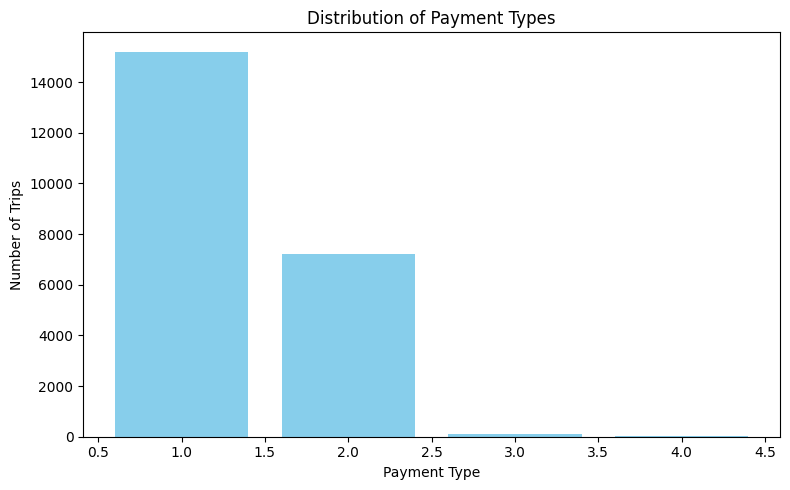

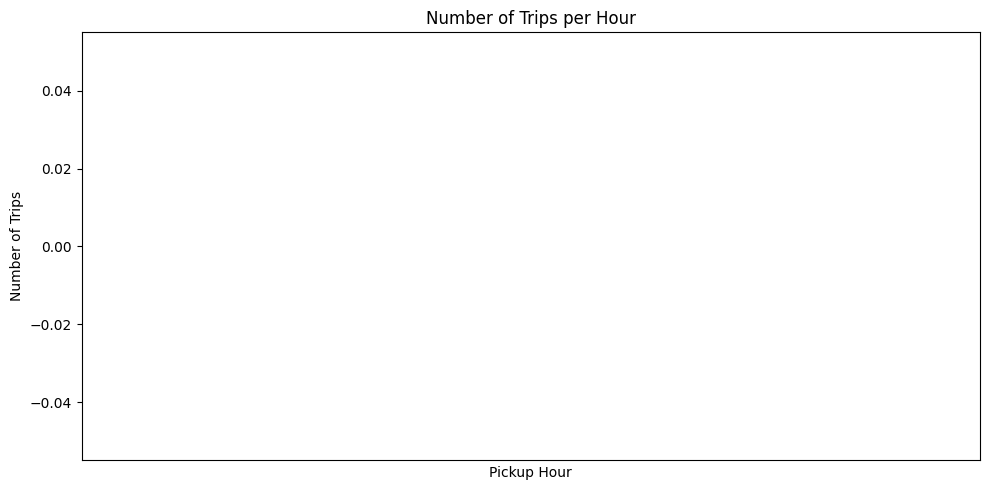

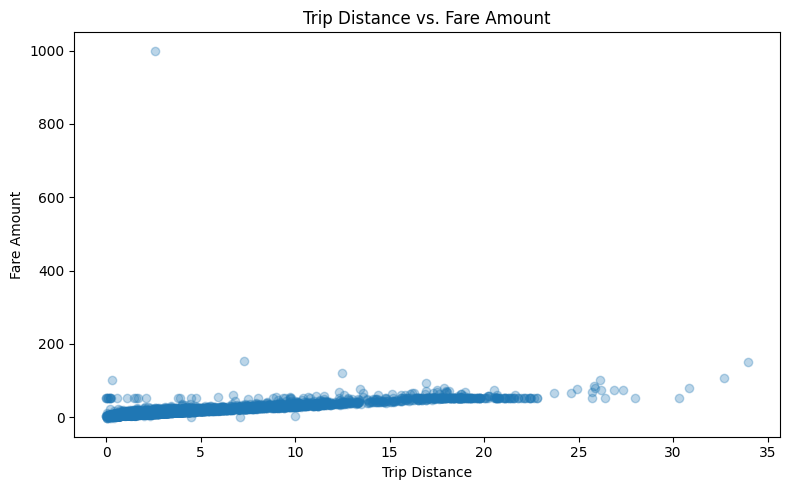

In [0]:
%python
import matplotlib.pyplot as plt
import numpy as np

# Drop NaN values from the payment_counts DataFrame
payment_counts_pd = payment_counts.dropna().toPandas()

# Bar chart: Distribution of payment types
plt.figure(figsize=(8, 5))
plt.bar(payment_counts_pd['payment_type'], payment_counts_pd['count'], color='skyblue')
plt.xlabel('Payment Type')
plt.ylabel('Number of Trips')
plt.title('Distribution of Payment Types')
plt.tight_layout()
plt.show()

# Drop NaN values from the hour_hist DataFrame
hour_hist_pd = hour_hist.dropna().toPandas()

# Line chart: Number of trips per hour
plt.figure(figsize=(10, 5))
plt.plot(hour_hist_pd['pickup_hour'], hour_hist_pd['count'], marker='o')
plt.xlabel('Pickup Hour')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Hour')
plt.xticks(hour_hist_pd['pickup_hour'])
plt.tight_layout()
plt.show()

# Drop NaN values from the sample DataFrame
sample_df = df_spark_1_clean.select('trip_distance', 'fare_amount').dropna(subset=['trip_distance', 'fare_amount']).limit(10000).toPandas()

# Scatter plot: Trip distance vs. fare amount
plt.figure(figsize=(8, 5))
plt.scatter(sample_df['trip_distance'], sample_df['fare_amount'], alpha=0.3)
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.title('Trip Distance vs. Fare Amount')
plt.tight_layout()
plt.show()

In [0]:
# Save cleaned and joined DataFrame as Parquet
df_spark_1_clean.write.mode('overwrite').parquet('dbfs:/mnt/blob/df_spark_1_clean.parquet')

# Export aggregated results as CSV
payment_counts.write.mode('overwrite').option('header', True).csv('dbfs:/mnt/blob/payment_counts.csv')
hour_hist.write.mode('overwrite').option('header', True).csv('dbfs:/mnt/blob/hour_hist.csv')

# Write summary to Markdown file
summary = """
# Summary of Findings

- **Average Trip Duration and Fare Amount:** Calculated for the dataset.
- **Payment Types:** Distribution analyzed; most common payment types identified.
- **Peak Hours:** Number of trips per hour shows peak demand periods.
- **Top Locations:** Top 5 pickup and dropoff locations by trip frequency identified.
- **Trip Distance vs. Fare Amount:** Scatter plot visualizes the relationship.

All results and data have been exported to Blob Storage.
"""

with open('/dbfs/mnt/blob/summary.md', 'w') as f:
    f.write(summary)

In [0]:
# Share Blob Storage links with your team
blob_links = {
    "Cleaned Data (Parquet)": "dbfs:/mnt/blob/df_spark_1_clean.parquet",
    "Payment Counts (CSV)": "dbfs:/mnt/blob/payment_counts.csv",
    "Hourly Trip Histogram (CSV)": "dbfs:/mnt/blob/hour_hist.csv",
    "Summary Report (Markdown)": "dbfs:/mnt/blob/summary.md"
}

for name, link in blob_links.items():
    print(f"{name}: {link}")

Cleaned Data (Parquet): dbfs:/mnt/blob/df_spark_1_clean.parquet
Payment Counts (CSV): dbfs:/mnt/blob/payment_counts.csv
Hourly Trip Histogram (CSV): dbfs:/mnt/blob/hour_hist.csv
Summary Report (Markdown): dbfs:/mnt/blob/summary.md
